# In-Depth: Support Vector Machines

Машины опорных векторов (SVM) представляют собой особенно мощный и гибкий класс контролируемых алгоритмов как для классификации, так и для регрессии.
В этом разделе мы разовьем интуицию, стоящую за машинами опорных векторов и их использованием в задачах классификации.

Начнем со стандартного импорта:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

 *дискриминационную классификацию*: вместо моделирования каждого класса мы просто находим линию или кривую (в двух измерениях) или многообразие (в нескольких измерениях), которые отделяют классы друг от друга.

В качестве примера рассмотрим простой случай задачи классификации, в которой два класса точек хорошо разделены:

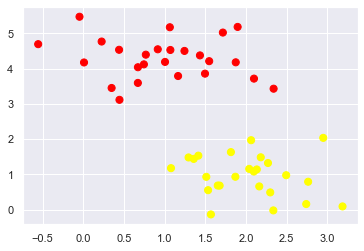

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Линейный дискриминационный классификатор попытается провести прямую линию, разделяющую два набора данных, и тем самым создать модель для классификации.
Для двумерных данных, подобных показанным здесь, эту задачу мы могли бы выполнить вручную.
Но сразу же мы видим проблему: существует более одной возможной разделительной линии, которая может идеально различить два класса!

Мы можем нарисовать их следующим образом:

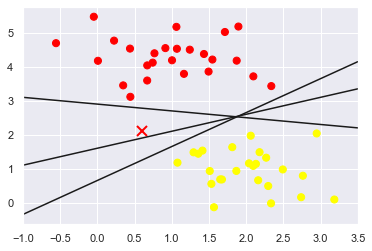

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Это три *очень* разных сепаратора, которые, тем не менее, прекрасно различают эти образцы.
В зависимости от того, что вы выберете, новой точке данных (например, отмеченной «X» на этом графике) будет присвоена другая метка!
Очевидно, нашей простой интуиции «провести черту между классами» недостаточно, и нам нужно подумать немного глубже.

## Машины опорных векторов: максимизация *маржи*

Машины опорных векторов предлагают один из способов улучшить это.
Интуиция такова: вместо того, чтобы просто рисовать линию нулевой ширины между классами, мы можем нарисовать вокруг каждой линии *поле* некоторой ширины, вплоть до ближайшей точки.
Вот пример того, как это может выглядеть:

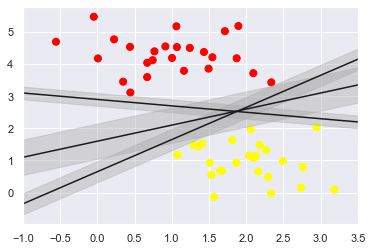

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

В машинах опорных векторов линия, которая максимизирует этот запас, будет той, которую мы выберем в качестве оптимальной модели.
Машины опорных векторов являются примером такой оценки *максимальной маржи*.

### Fitting a support vector machine

Давайте посмотрим на результат фактического соответствия этим данным: мы будем использовать классификатор опорных векторов Scikit-Learn для обучения модели SVM на этих данных.
На данный момент мы будем использовать линейное ядро и установим для параметра ``C`` очень большое число (сейчас мы обсудим их значение более подробно).

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Чтобы лучше представить, что здесь происходит, давайте создадим быструю удобную функцию, которая будет отображать для нас границы решений SVM:

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

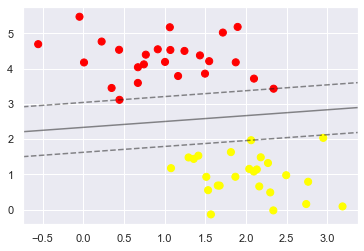

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Это разделительная линия, которая максимизирует разницу между двумя наборами точек.
Обратите внимание, что несколько точек обучения просто касаются поля: на этом рисунке они обозначены черными кружками.
Эти точки являются ключевыми элементами этой подгонки и известны как *опорные векторы*, что дало название алгоритму.
В Scikit-Learn идентификаторы этих точек хранятся в атрибуте ``support_vectors_`` классификатора:

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Ключом к успеху этого классификатора является то, что для подбора имеет значение только положение опорных векторов; любые точки дальше от поля, которые находятся на правильной стороне, не изменяют посадку!
Технически это связано с тем, что эти точки не вносят вклад в функцию потерь, используемую для подбора модели, поэтому их положение и количество не имеют значения, пока они не пересекают границу.

Мы можем увидеть это, например, если мы построим модель, полученную из первых 60 точек и первых 120 точек этого набора данных:

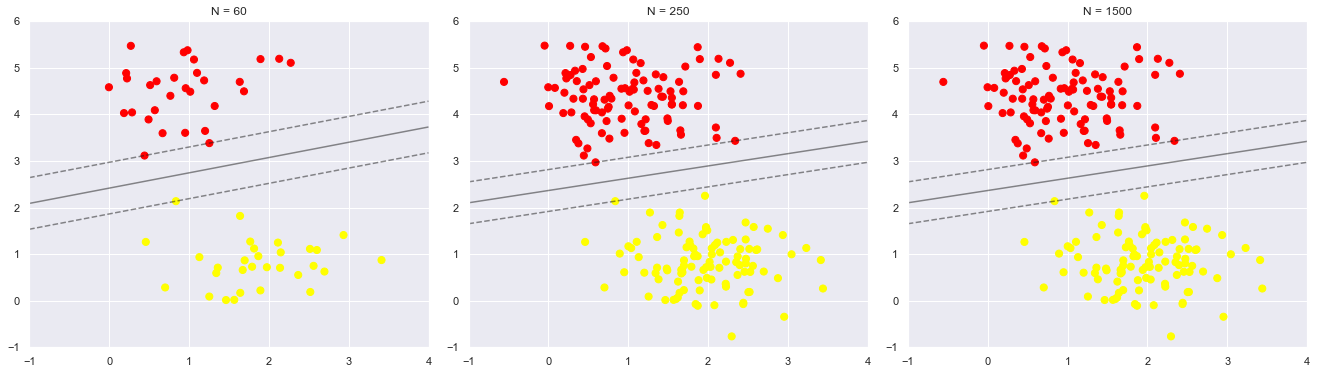

In [13]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 250,1500]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

На левой панели мы видим модель и опорные векторы для 60 обучающих точек.
На правой панели мы удвоили количество точек обучения, но модель не изменилась: три опорных вектора с левой панели по-прежнему являются опорными векторами с правой панели.
Эта нечувствительность к точному поведению удаленных точек является одной из сильных сторон модели SVM.

Если вы используете эту записную книжку в режиме реального времени, вы можете использовать интерактивные виджеты IPython для интерактивного просмотра этой функции модели SVM:

In [12]:
!pip3 install ipywidgets

In [14]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10,30, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 30, 200), value=10), Output()), _dom_classes=('wi…


Чтобы мотивировать потребность в ядрах, давайте посмотрим на некоторые данные, которые не являются линейно разделимыми:

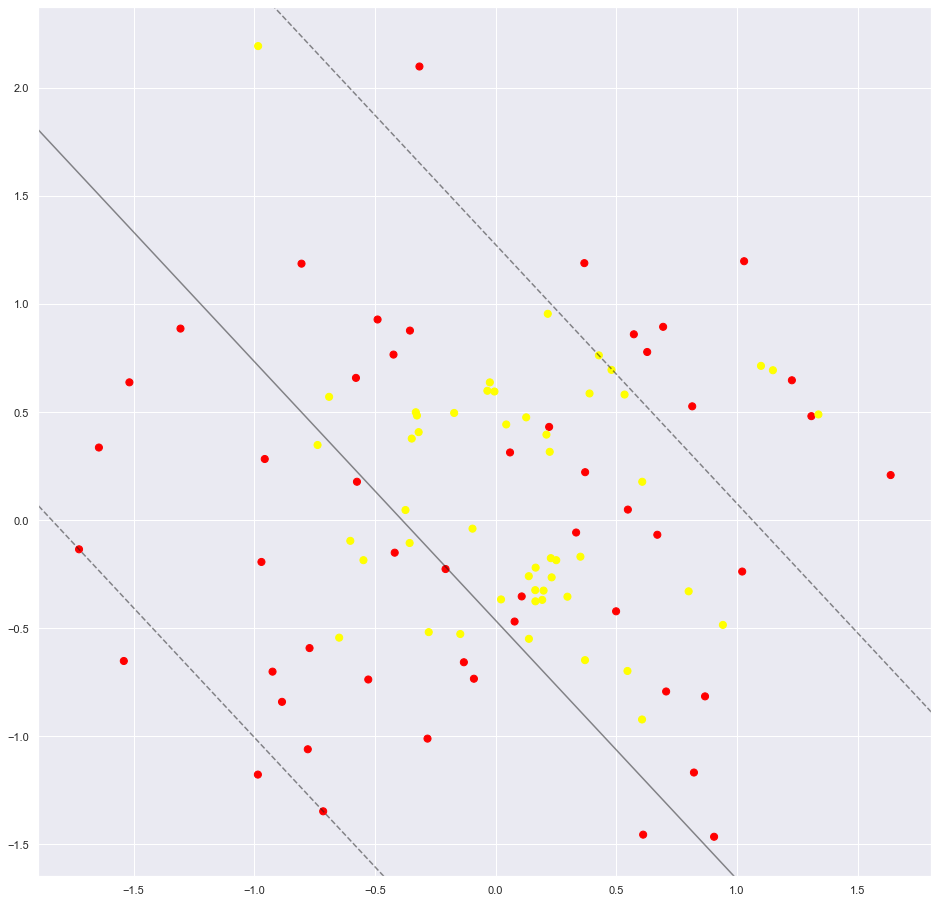

In [25]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.5) #noise=.2

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Ясно, что никакая линейная дискриминация *никогда* не сможет разделить эти данные.
Но мы можем извлечь урок из регрессии базисной функции в [Подробно: линейная регрессия] (05.06-Linear-Regression.ipynb) и подумать о том, как мы можем спроецировать данные в более высокое измерение, чтобы линейный разделитель *был* быть достаточным.
Например, мы могли бы использовать одну простую проекцию для вычисления *радиальной базисной функции* с центром в среднем скоплении:

In [26]:
r = np.exp(-(X ** 2).sum(1))

Мы можем визуализировать это дополнительное измерение данных с помощью трехмерного графика — если вы работаете с этой записной книжкой в реальном времени, вы сможете использовать ползунки для поворота графика:

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 16)

In [28]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

Мы можем видеть, что с этим дополнительным измерением данные становятся тривиально линейно разделимыми, рисуя разделяющую плоскость, скажем, *r*=0,7.

Здесь нам нужно было выбрать и тщательно настроить нашу проекцию: если бы мы не центрировали нашу радиальную базисную функцию в правильном месте, мы бы не увидели таких чистых, линейно разделимых результатов.
В общем, необходимость делать такой выбор — проблема: хотелось бы как-то автоматически находить лучшие базовые функции для использования.

Одна из стратегий для этого состоит в том, чтобы вычислить базисную функцию с центром в *каждой* точке набора данных и позволить алгоритму SVM просеивать результаты.
Этот тип преобразования базисной функции известен как *ядерное преобразование*, поскольку он основан на отношении подобия (или ядре) между каждой парой точек.

Потенциальная проблема с этой стратегией — проецирование $N$ точек в $N$ измерения — заключается в том, что она может стать очень ресурсоемкой по мере роста $N$.
Однако из-за изящной маленькой процедуры, известной как [*ядерный трюк*] (https://en.wikipedia.org/wiki/Kernel_trick), подгонка данных, преобразованных ядром, может выполняться неявно, т. построение полного $N$-мерного представления проекции ядра!
Этот трюк с ядром встроен в SVM и является одной из причин, по которой этот метод настолько эффективен.

В Scikit-Learn мы можем применить ядерную SVM, просто изменив наше линейное ядро ​​на ядро ​​RBF (радиальная базисная функция), используя гиперпараметр модели «ядро»:

In [35]:
clf = SVC(kernel='rbf', C=1) #1E5
clf.fit(X, y)

SVC(C=1)

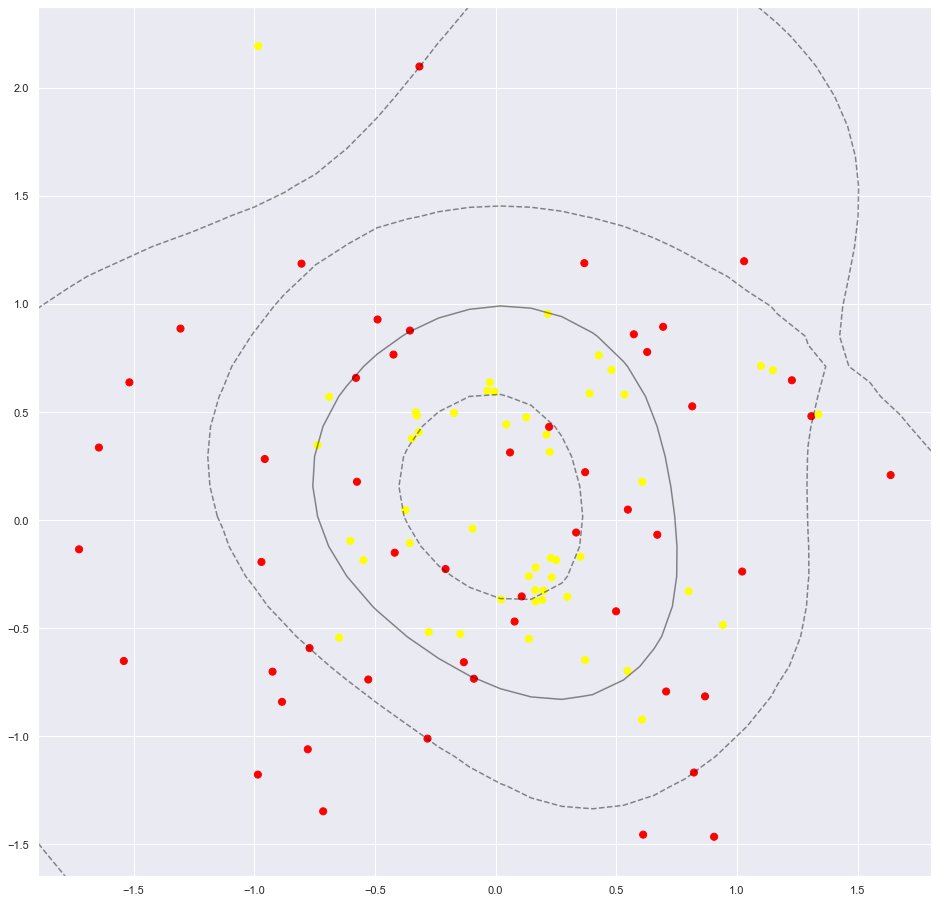

In [36]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

In [34]:
clf.support_vectors_

array([[ 0.62826313,  0.77717936],
       [ 0.81486081,  0.52574033],
       [ 1.02200599, -0.23873051],
       [-0.7711131 , -0.59287852],
       [ 0.86800834, -0.81633594],
       [ 0.10820632, -0.35386125],
       [-0.5787359 ,  0.65733544],
       [-0.13150747, -0.65838131],
       [ 0.22186664,  0.43054986],
       [-0.41815573, -0.15145949],
       [ 1.22795455,  0.64633921],
       [-0.20744465, -0.22708748],
       [ 0.54814122,  0.04793077],
       [ 1.30872603,  0.48029686],
       [-0.08990287, -0.73471048],
       [ 0.05981062,  0.31231458],
       [ 0.49936931, -0.42267401],
       [ 0.07873655, -0.47003117],
       [ 0.67024098, -0.06848031],
       [-0.57459105,  0.17677503],
       [ 1.63733257,  0.2076981 ],
       [ 0.57293902,  0.85908633],
       [ 0.69427011,  0.89360013],
       [-0.95672916,  0.28202367],
       [ 0.33372081, -0.05814113],
       [ 0.37108538,  0.22103131],
       [-0.42313219,  0.76515832],
       [ 0.70675669, -0.79369575],
       [ 0.21622846,

С помощью этой ядерной машины опорных векторов мы изучаем подходящую нелинейную границу решения.
Эта стратегия преобразования ядра часто используется в машинном обучении для превращения быстрых линейных методов в быстрые нелинейные методы, особенно для моделей, в которых можно использовать трюк с ядром.

### Настройка SVM: смягчение полей

Наше обсуждение до сих пор было сосредоточено вокруг очень чистых наборов данных, в которых существует идеальная граница решения.
Но что, если ваши данные частично совпадают?
Например, у вас могут быть такие данные

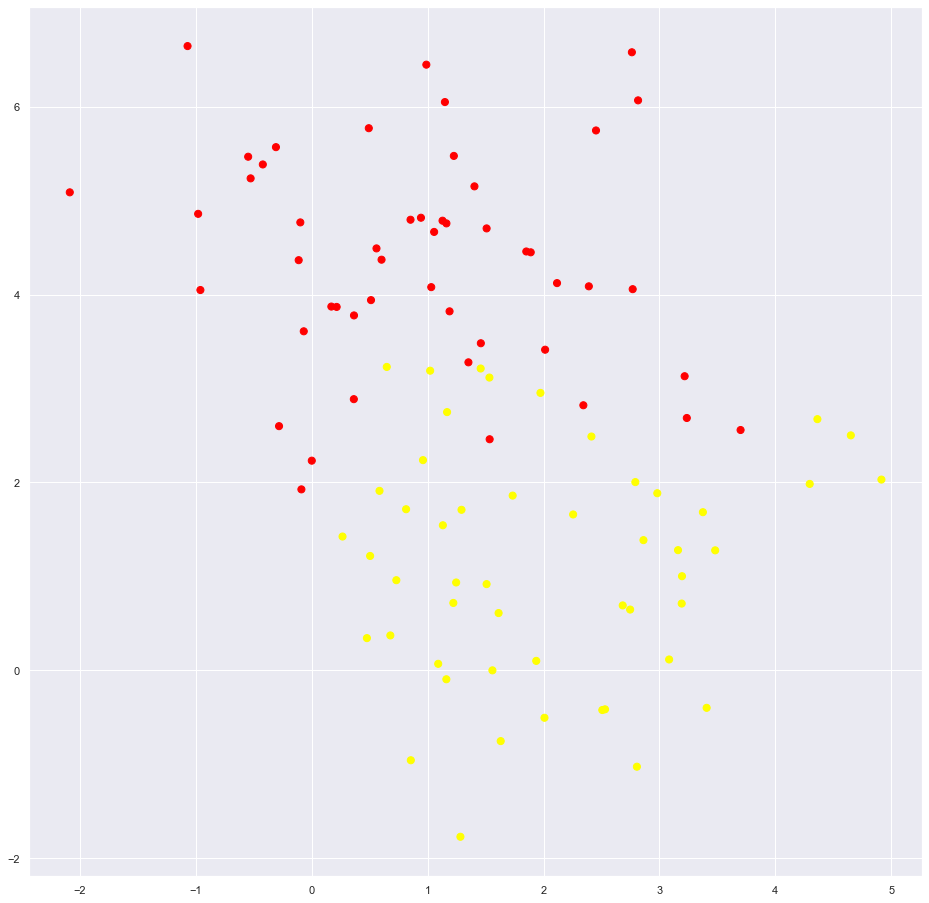

In [37]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Чтобы справиться с этим случаем, в реализации SVM есть некоторый фактор выдумки, который «смягчает» поля: то есть он позволяет некоторым точкам проникать в поля, если это позволяет лучше соответствовать.
Твердость края контролируется параметром настройки, чаще всего известным как $C$.
Для очень больших $C$ маржа жесткая, и баллы не могут лежать в ней.
Для меньших $C$ маржа мягче и может увеличиваться, чтобы охватывать некоторые точки.

График, показанный ниже, дает визуальное представление о том, как изменение параметра $C$ влияет на окончательную подгонку за счет смягчения поля:

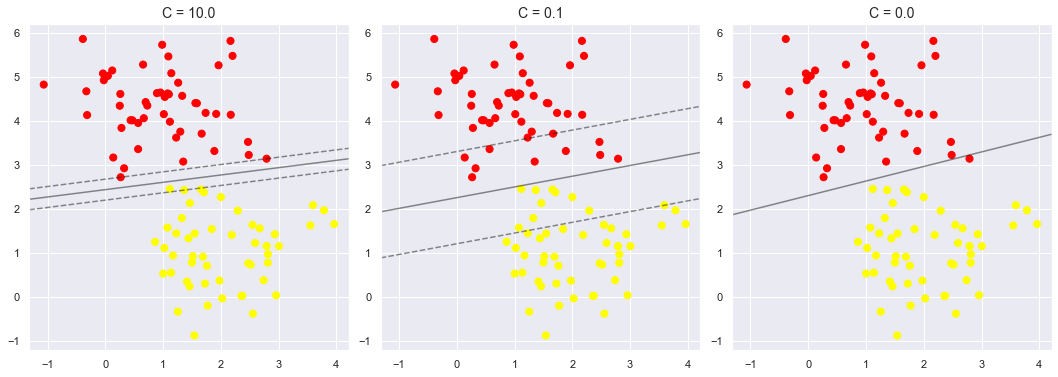

In [38]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1,0.001]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Оптимальное значение параметра $C$ будет зависеть от вашего набора данных и должно быть настроено с помощью перекрестной проверки или аналогичной процедуры (обратитесь к [Гиперпараметры и проверка модели](05.03-Hyperparameters-and-Model-Validation.ipynb) ).

## Пример: распознавание лиц

В качестве примера работы метода опорных векторов рассмотрим задачу распознавания лиц.
Мы будем использовать набор данных Labeled Faces in the Wild, который состоит из нескольких тысяч сопоставленных фотографий различных общественных деятелей.
Сборщик для набора данных встроен в Scikit-Learn:

In [39]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Давайте нарисуем несколько таких граней, чтобы увидеть, с чем мы работаем:

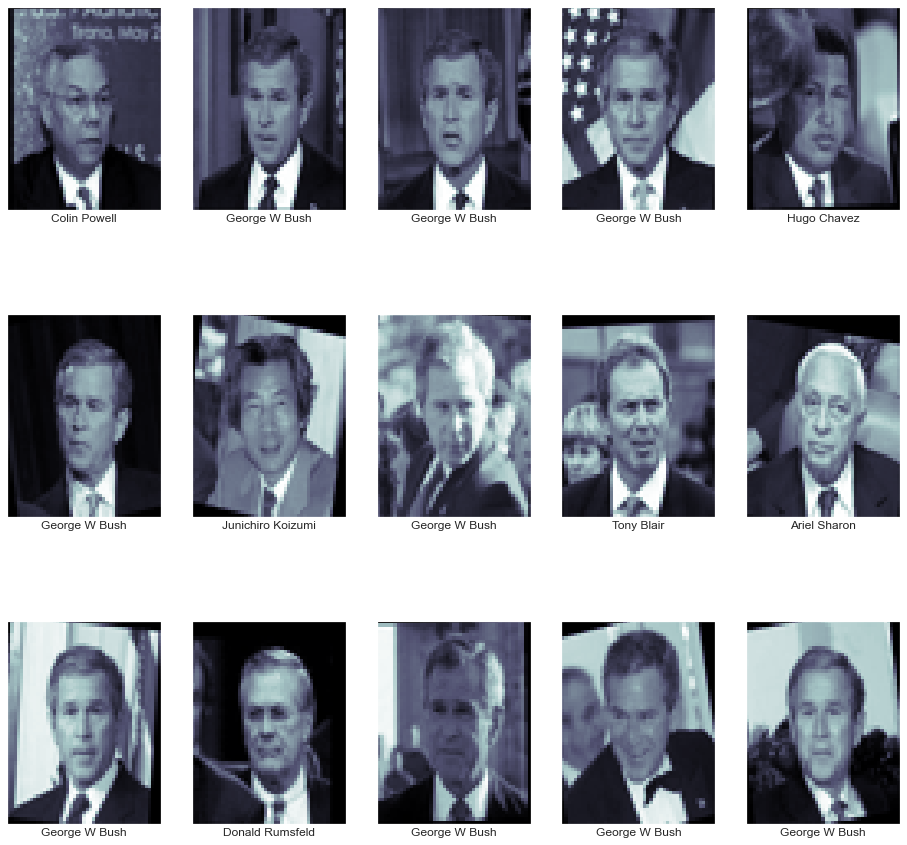

In [40]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Каждое изображение содержит [62×47] или около 3000 пикселей.
Мы могли бы просто использовать значение каждого пикселя в качестве функции, но часто более эффективно использовать какой-либо препроцессор для извлечения более значимых функций; здесь мы будем использовать анализ основных компонентов (см. [Подробно: анализ основных компонентов] (05.09-Principal-Component-Analysis.ipynb)) для извлечения 150 основных компонентов для ввода в наш машинный классификатор опорных векторов.
Мы можем сделать это проще всего, упаковав препроцессор и классификатор в один конвейер:

In [48]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Для проверки вывода нашего классификатора мы разделим данные на набор для обучения и тестирования:

In [42]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Наконец, мы можем использовать перекрестную проверку поиска по сетке для изучения комбинаций параметров.
Здесь мы настроим «C» (который управляет жесткостью поля) и «gamma» (который управляет размером ядра радиальной базисной функции) и определим лучшую модель:

In [46]:
from sklearn.model_selection import GridSearchCV
model = SVC(kernel='rbf', class_weight='balanced')
param_grid = {'C': [10,50],
              'gamma': [0.00005,0.0005,0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)
print(grid.best_score_)

Wall time: 39.1 s
{'C': 50, 'gamma': 0.0005}
0.7576598546554163


In [47]:
from sklearn.svm import NuSVR 
model = NuSVR()
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10,50], 'nu': [1,0.5, 0.05, 0.005]}
grid = GridSearchCV(model, param_grid)
grid.fit(Xtrain, ytrain)
print(grid.best_params_)
print(grid.best_score_)

{'C': 10, 'nu': 1}
0.5300326767858192


Оптимальные значения попадают в середину нашей сетки; если бы они попадали по краям, мы хотели бы расширить сетку, чтобы убедиться, что мы нашли истинный оптимум.

Теперь с помощью этой модели с перекрестной проверкой мы можем предсказать метки для тестовых данных, которые модель еще не видела:

In [45]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Давайте посмотрим на несколько тестовых изображений вместе с их предсказанными значениями:

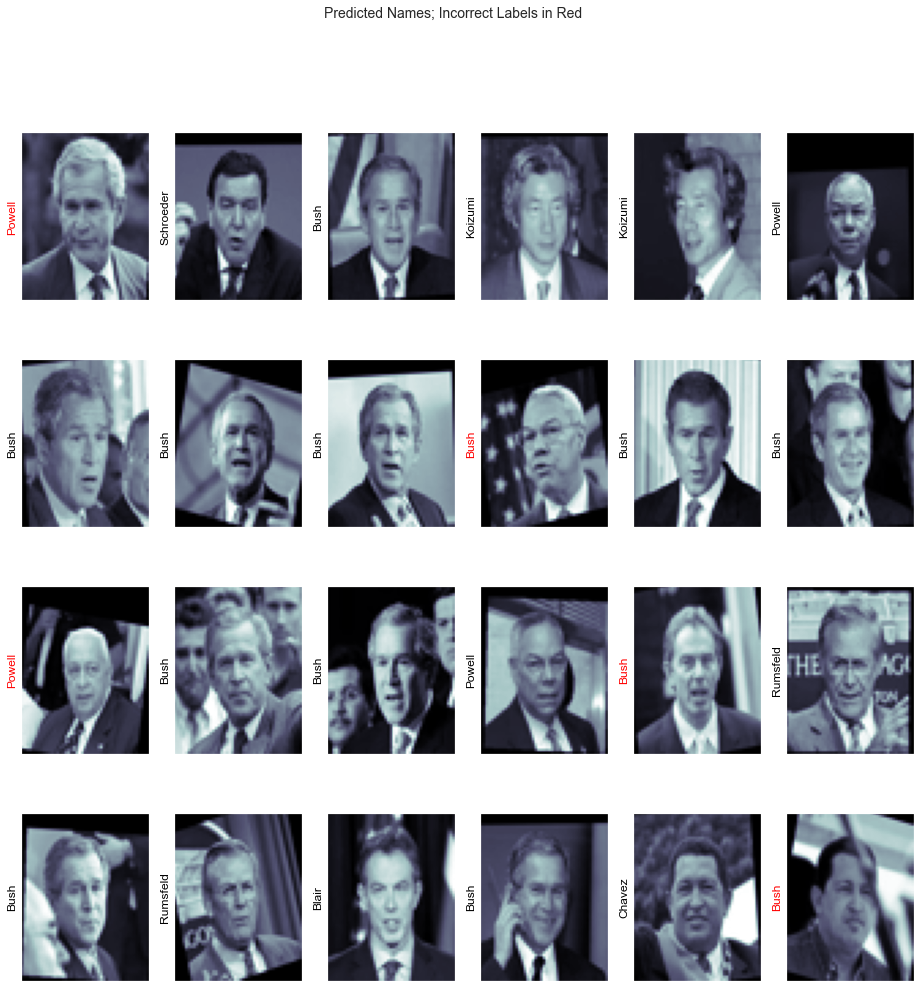

In [25]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Из этой небольшой выборки наша оптимальная оценка неправильно обозначила только одно лицо (буква Буша).
лицо в нижнем ряду было ошибочно помечено как Блэр).
Мы можем лучше понять производительность нашего оценщика, используя отчет о классификации, в котором метка за меткой приводится статистика восстановления:

In [26]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.67      0.77        15
     Colin Powell       0.84      0.85      0.85        68
  Donald Rumsfeld       0.72      0.58      0.64        31
    George W Bush       0.76      0.92      0.83       126
Gerhard Schroeder       0.75      0.65      0.70        23
      Hugo Chavez       1.00      0.45      0.62        20
Junichiro Koizumi       0.91      0.83      0.87        12
       Tony Blair       0.80      0.76      0.78        42

         accuracy                           0.80       337
        macro avg       0.84      0.71      0.76       337
     weighted avg       0.80      0.80      0.79       337



Мы также можем отобразить матрицу путаницы между этими классами:

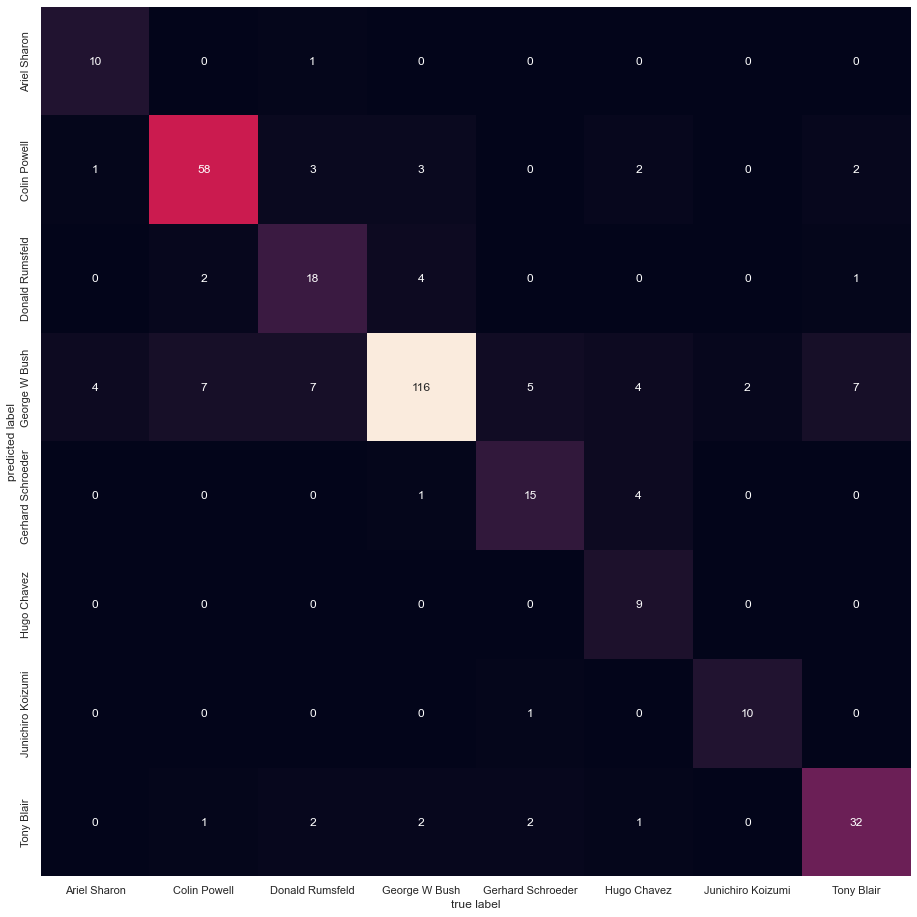

In [27]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Это помогает нам понять, какие метки могут быть перепутаны оценщиком.

Для реальной задачи распознавания лиц, в которой фотографии не обрезаются заранее в красивые сетки, единственное отличие схемы классификации лиц заключается в выборе признаков: вам потребуется использовать более сложный алгоритм для поиска лиц, и извлекайте функции, которые не зависят от пикселизации.
Для такого рода приложений хорошим вариантом является использование [OpenCV] (http://opencv.org), который, среди прочего, включает в себя предварительно обученные реализации современных инструментов извлечения признаков для образы вообще и лица в частности.

## Сводная информация о машине опорных векторов

Мы увидели здесь краткое интуитивное введение в принципы, лежащие в основе машин опорных векторов.
Эти методы являются мощным методом классификации по ряду причин:

- Их зависимость от относительно небольшого числа опорных векторов означает, что они являются очень компактными моделями и занимают очень мало памяти.
- После того, как модель обучена, фаза прогнозирования выполняется очень быстро.
- Поскольку на них влияют только точки рядом с границей, они хорошо работают с многомерными данными — даже с данными с большим количеством измерений, чем выборки, что является сложным режимом для других алгоритмов.
- Их интеграция с методами ядра делает их очень универсальными, способными адаптироваться ко многим типам данных.

Однако у SVM есть и несколько недостатков:

- Масштабирование с количеством выборок $N$ равно $\mathcal{O}[N^3]$ в худшем случае или $\mathcal{O}[N^2]$ для эффективных реализаций. Для большого количества обучающих выборок эти вычислительные затраты могут быть непомерно высокими.
- Результаты сильно зависят от правильного выбора параметра смягчения $C$. Это должно быть тщательно выбрано с помощью перекрестной проверки, которая может быть дорогостоящей по мере увеличения размера наборов данных.
- Результаты не имеют прямой вероятностной интерпретации. Это можно оценить с помощью внутренней перекрестной проверки (см. параметр «вероятность» в «SVC»), но эта дополнительная оценка является дорогостоящей.

Помня об этих особенностях, я обычно обращаюсь к SVM только после того, как другие более простые, быстрые и менее требовательные к настройке методы оказались недостаточными для моих нужд.
Тем не менее, если у вас есть циклы ЦП для обучения и перекрестной проверки SVM на ваших данных, этот метод может привести к отличным результатам.